# CNN Cat-Dog Classifier

In [4]:
import tensorflow as tf
print('tensorflow version: {}'.format(tf.__version__))

tensorflow version: 1.14.0


## 1. 패키지 로드

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from tensorflow.keras import layers
import tensorflow as tf
import check_util.checker as checker

from PIL import Image
from IPython.display import clear_output
import os
import time
import re
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tf.enable_eager_execution()
print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

tensorflow version: 1.14.0
GPU 사용 가능 여부: False


# 2. 데이터 셋 다운로드 및 훈련, 검증, 테스트 데이터셋 구분

In [1]:
import zipfile
from pathlib import Path

current_path = Path().absolute()
data_path = current_path / "data"
print("현재 디렉토리 위치: {}".format(current_path))
if (data_path / "my_cat_dog").exists():
    print("이미 'data/my_cat_dog' 폴더에 압축이 풀려있습니다. 확인해보세요!")
else:
    with zipfile.ZipFile(str(data_path / "my_cat_dog.zip"), "r") as zip_ref:
        zip_ref.extractall(str(data_path / "my_cat_dog"))
    print("Done!")

현재 디렉토리 위치: C:\Users\JJun\ML_DL\CNN
이미 'data/my_cat_dog' 폴더에 압축이 풀려있습니다. 확인해보세요!


In [5]:
data_dir = './data/my_cat_dog'  # 압축 해제된 데이터셋의 디렉토리 경로

## 3. 하이퍼파라미터 세팅

In [7]:
batch_size = 20
max_epochs = 20
learning_rate = 1e-4
IMG_SIZE = 150

In [8]:
def load(image_file, label):
    # 해당경로의 파일을 읽어서 float 타입으로 변환
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)

    return image, label

label: 0


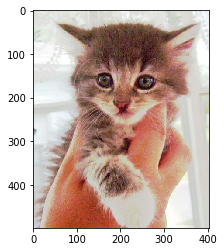

In [9]:
image, label = load(os.path.join(data_dir, 'train/cat/cat.100.jpg'), 0)
# casting to int for matplotlib to show the image
print("label: {}".format(label))
plt.figure()
plt.imshow(image/255.0)

In [10]:
def resize(input_image, height, width):    
    input_image = tf.image.resize_images(input_image,(height,width))
   
    return input_image

In [12]:
def random_rotation(input_image):    
    angles = tf.random.uniform([1],-0.3,0.3)
    rotated_image = tf.contrib.image.rotate(input_image,angles)   

    return rotated_image

In [13]:
def random_crop(input_image, crop_size):    
    assert isinstance(crop_size, int), "crop_size 는 정수형태여야 합니다."
    
    cropped_image = tf.image.random_crop(input_image,(crop_size,crop_size,3))
   

    return cropped_image

In [15]:
# normalizing the images to [-1, 1]
def normalize(input_image):
    
    input_image = (input_image/127.5)-1.
   

    return input_image

In [17]:
def random_jitter(input_image):
    
    # resizing to 176 x 176 x 3
    input_image = resize(input_image,176,176)

    # randomly cropping to 150 x 150 x 3
    input_image = random_crop(input_image,150)

    # randomly rotation
    input_image = random_rotation(input_image)

    # randomly mirroring
    input_image = tf.image.random_flip_left_right(input_image)
    

    return input_image

In [18]:
def central_crop(input_image):   
    
    # resizing to 176 x 176 x 3
    input_image = resize(input_image,176,176)

    # central cropping to 150 x 150 x 3
    input_image = tf.image.central_crop(input_image,150./176.)   

    return input_image

In [20]:
def load_image_train(image_file, label):
    
    input_image, label = load(image_file, label)
    input_image = random_jitter(input_image)
    input_image = normalize(input_image)
    

    return input_image, label

In [22]:
def load_image_val_and_test(image_file, label):
    
    input_image, label = load(image_file, label)
    input_image = central_crop(input_image)
    input_image = normalize(input_image)
    

    return input_image, label

# Input data pipeline  

In [23]:
def add_label(image_file, label):
    return image_file, label
  
def get_dataset(mode, data_dir='./data/my_cat_dog'):    
    folder_list = [f for f in os.listdir(
        os.path.join(data_dir, mode)) if not f.startswith('.')]
   
    dataset = tf.data.Dataset.list_files(                               # 1번
        os.path.join(data_dir, mode, folder_list[0], '*.jpg'))
    dataset = dataset.map(lambda x: add_label(x, 0))                    # 2번
    for label, category_name in enumerate(folder_list[1:], 1):          # 3번
        temp_dataset = tf.data.Dataset.list_files(                      # 4번
            os.path.join(data_dir, mode, category_name, '*.jpg'))
        temp_dataset = temp_dataset.map(lambda x: add_label(x, label))  # 5번
        dataset = dataset.concatenate(temp_dataset)                     # 6번
    return dataset

In [24]:
# train_dataset
train_dataset = get_dataset(mode="train", data_dir=data_dir)

N = BUFFER_SIZE = len(list(train_dataset))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,   num_parallel_calls=16)
train_dataset = train_dataset.batch(batch_size)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [25]:
# val_dataset
val_dataset = get_dataset(mode="val", data_dir=data_dir)
val_dataset = val_dataset.map(load_image_val_and_test)
val_dataset = val_dataset.batch(batch_size)

# test_dataset
test_dataset = get_dataset(mode="val", data_dir=data_dir)
test_dataset = test_dataset.map(load_image_val_and_test)
test_dataset = test_dataset.batch(batch_size)

# Augmented image 출력

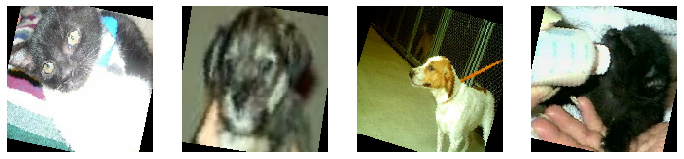

In [27]:
for images, labels in train_dataset.take(1):
    break
fig, axes = plt.subplots(1, 4, figsize=(12, 20))
for i, ax in enumerate(axes):
    ax.imshow(images[i].numpy()*0.5+0.5)
    ax.axis("off")
plt.show()

# 네트워크 설계



In [28]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(filters=num_filters,kernel_size=kernel_size)
        self.bn = tf.keras.layers.BatchNormalization() 
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPool2D()
        

    def call(self, inputs, training=True):
       
        x = self.conv(inputs)    # self.conv forward
        x = self.bn(x)    # self.bn   forward
        x = self.relu(x)    # self.relu forward
        x = self.pool(x)    # self.pool forward
       

        return x

In [30]:
class SimpleCNN(tf.keras.Model):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = Conv(32,3)
        self.conv2 = Conv(64,3)
        self.conv3 = Conv(128,3)
        self.conv4 = Conv(128,3)

        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=512,activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=2,activation='softmax')
       

    def call(self, inputs, training=True):
       
        x = self.conv1(inputs)    # self.conv1 forward
        x = self.conv2(x)    # self.conv2 forward
        x = self.conv3(x)    # self.conv3 forward
        x = self.conv4(x)    # self.conv4 forward
        x = self.flatten(x)    # flatten 
        x = self.dense1(x)    # self.dense1 forward
        x = self.dense2(x)    # self.dense2 forward
       

        return x

In [31]:
model = SimpleCNN()
for images, labels in train_dataset.take(1):
    outputs = model(images, training=False)

In [32]:
model.summary()

Model: "simple_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv)                multiple                  1024      
_________________________________________________________________
conv_2 (Conv)                multiple                  18752     
_________________________________________________________________
conv_3 (Conv)                multiple                  74368     
_________________________________________________________________
conv_4 (Conv)                multiple                  148096    
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3211776   
_________________________________________________________________
dense_1 (Dense)              multiple                  1

# Loss function, Optimizer 정의



In [34]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


In [35]:
mean_loss = tf.keras.metrics.Mean("loss")
mean_accuracy = tf.keras.metrics.Accuracy("accuracy")

# train, validation, test 함수 정의


In [37]:
def train_step(model, images, labels):
    
    with tf.GradientTape() as tape:
        predictions = model(images,training=True)    
        loss_value = loss_object(tf.one_hot(labels,2),predictions)     

    gradients = tape.gradient(loss_value,model.trainable_variables)               
    optimizer.apply_gradients(zip(gradients,model.trainable_variables)) 
    
    
    mean_accuracy(labels, tf.argmax(predictions, axis=1))

    return loss_value

In [38]:
def validation(model, val_dataset, epoch):
    print('Start validation..')
    val_mean_loss = tf.keras.metrics.Mean("val_loss")
    val_mean_accuracy = tf.keras.metrics.Accuracy("val_acc")

    for step, (images, labels) in enumerate(val_dataset):
       
        predictions = model(images,training=False)       
        val_loss_value = loss_object(tf.one_hot(labels,2),predictions)    
       
        val_mean_loss(val_loss_value)
        val_mean_accuracy(labels, tf.argmax(predictions, axis=1))
        
    print('Validation #{} epoch  Average Loss: {:.4g}  Accuracy: {:.4g}%\n'.format(
        epoch, val_mean_loss.result(), val_mean_accuracy.result() * 100))

    return val_mean_loss.result(), val_mean_accuracy.result()

In [39]:
def test(model, test_dataset):
    print('Start test..')
    test_mean_accuracy = tf.keras.metrics.Accuracy("test_acc")

    for step, (images, labels) in enumerate(test_dataset):
       
        predictions = model(images,training=False)
        
        test_mean_accuracy(labels, tf.argmax(predictions, axis=1))
        
    print('Test accuracy: {:.4g}%'.format(test_mean_accuracy.result() * 100))

    return test_mean_accuracy.result()

### 모델 저장 함수 정의

In [40]:
def save_model(model, epoch, train_dir):
    model_name = 'my_model_' + str(epoch)
    model.save_weights(os.path.join(train_dir, model_name))

# Training


In [41]:
train_dir = os.path.join('./train/exp1')
print_steps = 25
val_epoch = 1

In [42]:
def main(model, train_dataset, val_dataset, val_epoch, print_steps, save_dir):
    print('Start training..')
    num_batches_per_epoch = len(list(train_dataset))
    global_step = 0
    best_acc = 0.

    for epoch in range(max_epochs):
        for step, (images, labels) in enumerate(train_dataset):
            start_time = time.time()
                        
            loss_value = train_step(model,images,labels)
            
            mean_loss(loss_value)
            global_step += 1

            if global_step % print_steps == 0:
                duration = time.time() - start_time
                examples_per_sec = batch_size / float(duration)
                print("Epochs: [{}/{}] step: [{}/{}] loss: {:.4g} acc: {:.4g}%  ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                    epoch+1, max_epochs, step+1, num_batches_per_epoch,
                    mean_loss.result(), mean_accuracy.result() * 100, examples_per_sec, duration))
        
        # clear the history            
        mean_loss.reset_states()
        mean_accuracy.reset_states()

        if (epoch + 1) % val_epoch == 0:
           
            val_mean_loss, val_mean_accuracy = validation(model,val_dataset,epoch)
           
            if val_mean_accuracy > best_acc:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save in {}\n'.format(save_dir))
                best_acc = val_mean_accuracy
                save_model(model, epoch+1, save_dir)

    print('training done..')

In [44]:
main(model, train_dataset, val_dataset, val_epoch, print_steps, save_dir=train_dir)

Start training..


W0826 15:11:27.501428  6900 deprecation.py:323] From C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epochs: [1/20] step: [25/100] loss: 0.7059 acc: 50.2%  (15.05 examples/sec; 1.329 sec/batch)
Epochs: [1/20] step: [50/100] loss: 0.6949 acc: 52.7%  (14.87 examples/sec; 1.345 sec/batch)
Epochs: [1/20] step: [75/100] loss: 0.6906 acc: 53.33%  (12.89 examples/sec; 1.552 sec/batch)
Epochs: [1/20] step: [100/100] loss: 0.6874 acc: 54.15%  (16.30 examples/sec; 1.227 sec/batch)
Start validation..
Validation #0 epoch  Average Loss: 0.6723  Accuracy: 59.5%

Best performance at epoch: 1
Save in ./train/exp1

Epochs: [2/20] step: [25/100] loss: 0.6697 acc: 59.6%  (15.55 examples/sec; 1.286 sec/batch)
Epochs: [2/20] step: [50/100] loss: 0.6599 acc: 60.5%  (15.53 examples/sec; 1.287 sec/batch)
Epochs: [2/20] step: [75/100] loss: 0.6542 acc: 61%  (15.72 examples/sec; 1.272 sec/batch)
Epochs: [2/20] step: [100/100] loss: 0.6607 acc: 60.25%  (15.82 examples/sec; 1.264 sec/batch)
Start validation..
Validation #1 epoch  Average Loss: 0.655  Accuracy: 60.5%

Best performance at epoch: 2
Save in ./train/

Epochs: [18/20] step: [25/100] loss: 0.3984 acc: 82%  (17.36 examples/sec; 1.152 sec/batch)
Epochs: [18/20] step: [50/100] loss: 0.4228 acc: 80.8%  (17.69 examples/sec; 1.131 sec/batch)
Epochs: [18/20] step: [75/100] loss: 0.404 acc: 81.67%  (17.47 examples/sec; 1.145 sec/batch)
Epochs: [18/20] step: [100/100] loss: 0.4071 acc: 80.95%  (18.04 examples/sec; 1.109 sec/batch)
Start validation..
Validation #17 epoch  Average Loss: 0.4998  Accuracy: 76.1%

Epochs: [19/20] step: [25/100] loss: 0.3831 acc: 83.6%  (17.24 examples/sec; 1.160 sec/batch)
Epochs: [19/20] step: [50/100] loss: 0.4067 acc: 82%  (17.55 examples/sec; 1.140 sec/batch)
Epochs: [19/20] step: [75/100] loss: 0.3988 acc: 82.2%  (17.99 examples/sec; 1.112 sec/batch)
Epochs: [19/20] step: [100/100] loss: 0.4029 acc: 82%  (18.41 examples/sec; 1.087 sec/batch)
Start validation..
Validation #18 epoch  Average Loss: 0.474  Accuracy: 78.3%

Best performance at epoch: 19
Save in ./train/exp1

Epochs: [20/20] step: [25/100] loss: 0.3

# 저장된 모델 불러오기 및 test


In [ ]:
model = SimpleCNN()  

for images, labels in train_dataset.take(1):
    outputs = model(images, training=False)

model.load_weights(tf.train.latest_checkpoint(train_dir))

In [ ]:
test_acc_value = test(model, test_dataset)

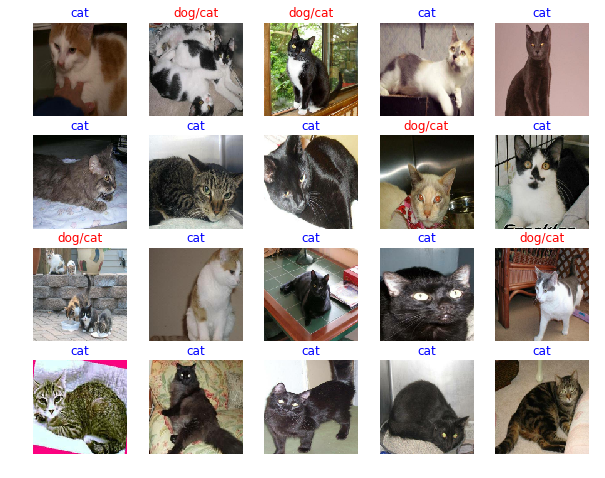

In [47]:
test_batch_size = 25

for images, labels in test_dataset.take(1):
    predictions = model(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'cat', 1: 'dog'}

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())],
                                   labels_map[py.numpy()]), color='red')
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')

# Transfer Learning



In [ ]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [49]:
def get_transfer_learning_model(conv_base):
    model = tf.keras.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    
    model.add(tf.keras.layers.Dense(units=256,activation='relu'))
    model.add(tf.keras.layers.Dense(units=2,activation='softmax'))
    
    return model

In [50]:
model = get_transfer_learning_model(conv_base)

for var in model.trainable_variables:
    print(var.name)

block1_conv1/kernel:0
block1_conv1/bias:0
block1_conv2/kernel:0
block1_conv2/bias:0
block2_conv1/kernel:0
block2_conv1/bias:0
block2_conv2/kernel:0
block2_conv2/bias:0
block3_conv1/kernel:0
block3_conv1/bias:0
block3_conv2/kernel:0
block3_conv2/bias:0
block3_conv3/kernel:0
block3_conv3/bias:0
block4_conv1/kernel:0
block4_conv1/bias:0
block4_conv2/kernel:0
block4_conv2/bias:0
block4_conv3/kernel:0
block4_conv3/bias:0
block5_conv1/kernel:0
block5_conv1/bias:0
block5_conv2/kernel:0
block5_conv2/bias:0
block5_conv3/kernel:0
block5_conv3/bias:0
dense_4/kernel:0
dense_4/bias:0
dense_5/kernel:0
dense_5/bias:0


In [51]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [52]:
for var in model.trainable_variables:
    print(var.name)

block5_conv1/kernel:0
block5_conv1/bias:0
block5_conv2/kernel:0
block5_conv2/bias:0
block5_conv3/kernel:0
block5_conv3/bias:0
dense_4/kernel:0
dense_4/bias:0
dense_5/kernel:0
dense_5/bias:0


In [54]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train_dir = os.path.join('./train/exp1/resnet')

### Training for fine tuning


In [55]:
main(model, train_dataset, val_dataset, val_epoch, print_steps, save_dir=train_dir)

Start training..
Epochs: [1/20] step: [25/100] loss: 0.428 acc: 77.6%  (3.45 examples/sec; 5.791 sec/batch)
Epochs: [1/20] step: [50/100] loss: 0.341 acc: 83.7%  (3.45 examples/sec; 5.795 sec/batch)
Epochs: [1/20] step: [75/100] loss: 0.2947 acc: 85.8%  (3.09 examples/sec; 6.482 sec/batch)
Epochs: [1/20] step: [100/100] loss: 0.2848 acc: 87%  (3.27 examples/sec; 6.107 sec/batch)
Start validation..
Validation #0 epoch  Average Loss: 0.1864  Accuracy: 90.3%

Best performance at epoch: 1
Save in ./train/exp1/resnet

Epochs: [2/20] step: [25/100] loss: 0.1759 acc: 93.6%  (3.19 examples/sec; 6.263 sec/batch)
Epochs: [2/20] step: [50/100] loss: 0.1604 acc: 94%  (3.07 examples/sec; 6.519 sec/batch)
Epochs: [2/20] step: [75/100] loss: 0.1487 acc: 94.6%  (3.06 examples/sec; 6.535 sec/batch)
Epochs: [2/20] step: [100/100] loss: 0.1317 acc: 95.35%  (3.34 examples/sec; 5.982 sec/batch)
Start validation..
Validation #1 epoch  Average Loss: 0.204  Accuracy: 93.2%

Best performance at epoch: 2
Save i

Epochs: [18/20] step: [75/100] loss: 0.0187 acc: 99.07%  (3.69 examples/sec; 5.426 sec/batch)
Epochs: [18/20] step: [100/100] loss: 0.02079 acc: 99.15%  (3.42 examples/sec; 5.845 sec/batch)
Start validation..
Validation #17 epoch  Average Loss: 0.1823  Accuracy: 95.6%

Epochs: [19/20] step: [25/100] loss: 0.04438 acc: 99%  (3.51 examples/sec; 5.702 sec/batch)
Epochs: [19/20] step: [50/100] loss: 0.03669 acc: 99.1%  (3.27 examples/sec; 6.121 sec/batch)
Epochs: [19/20] step: [75/100] loss: 0.03394 acc: 99.07%  (3.58 examples/sec; 5.585 sec/batch)
Epochs: [19/20] step: [100/100] loss: 0.03041 acc: 99.15%  (3.58 examples/sec; 5.583 sec/batch)
Start validation..
Validation #18 epoch  Average Loss: 0.1592  Accuracy: 95.8%

Epochs: [20/20] step: [25/100] loss: 0.01088 acc: 99.6%  (3.57 examples/sec; 5.605 sec/batch)
Epochs: [20/20] step: [50/100] loss: 0.03088 acc: 99%  (3.56 examples/sec; 5.621 sec/batch)
Epochs: [20/20] step: [75/100] loss: 0.02362 acc: 99.27%  (3.58 examples/sec; 5.583 sec

In [56]:
train_dir = './train/pretrained/resnet' 
model = get_transfer_learning_model(conv_base)
model.load_weights(tf.train.latest_checkpoint(train_dir))

In [57]:
test_acc_value = test(model, test_dataset)

Start test..
Test accuracy: 95.5%


---